In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained("modelo_treinado")
tokenizer = AutoTokenizer.from_pretrained("modelo_treinado")

In [4]:
# Carrega seu DataFrame
teste_df = pd.read_pickle("teste.pkl")
teste_df = teste_df.groupby('label').apply(lambda x: x.sample(n=500, random_state=1), include_groups=True).reset_index(drop=True)
teste_df.label = teste_df['label'].astype(int)
teste_df.sample(4, random_state=10)

/tmp/ipykernel_10481/289120843.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  teste_df = teste_df.groupby('label').apply(lambda x: x.sample(n=500, random_state=1), include_groups=True).reset_index(drop=True)


,mensagem,label
648,A Chanel não existiu sei la quantas décadas co...,1
331,Q depressão,0
1158,"Cadê vcs, mane",2
2300,Simplesmente estoico,4


In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(["Daniel Unirio", "Diogo", "Evangelista", "João Maurício", "Matheus Unirio"])
pd.DataFrame({"Autores": label_encoder.classes_, "Encoder": label_encoder.transform(label_encoder.classes_)})

,Autores,Encoder
0,Daniel Unirio,0
1,Diogo,1
2,Evangelista,2
3,João Maurício,3
4,Matheus Unirio,4


In [6]:
def evaluate_model(model, tokenizer, texts, batch_size=16):
    model.eval()
    all_predictions = []

    for i in tqdm.tqdm(range(0, len(texts), batch_size), desc="Avaliando"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True,
                           return_tensors="pt", max_length=512)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())

    return all_predictions

# batches pequenos, tenho pouca ram
predictions = evaluate_model(model, tokenizer, list(teste_df['mensagem'].values), batch_size=8)
predicted_labels = label_encoder.inverse_transform(predictions)

Avaliando: 100%|██████████| 313/313 [00:48<00:00,  6.45it/s]


In [7]:
true_labels = label_encoder.inverse_transform(teste_df['label'])
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))

                precision    recall  f1-score   support

 Daniel Unirio       0.60      0.57      0.58       500
         Diogo       0.53      0.57      0.55       500
   Evangelista       0.61      0.61      0.61       500
 João Maurício       0.64      0.68      0.66       500
Matheus Unirio       0.65      0.60      0.62       500

      accuracy                           0.60      2500
     macro avg       0.61      0.60      0.61      2500
  weighted avg       0.61      0.60      0.61      2500



In [8]:
text = "se o Daniel disser que tá fazendo sol, eu abro um guarda-chuva"

inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
predicted_label = torch.argmax(logits, dim=-1).item()
predicted_label_name = label_encoder.inverse_transform([predicted_label])[0]
print(f"Texto: {text}")
print(f"Autor previsto: {predicted_label_name} com probabilidade de {torch.max(torch.softmax(logits, dim=-1))*100:.2f}%")

Texto: se o Daniel disser que tá fazendo sol, eu abro um guarda-chuva
Autor previsto: Evangelista com probabilidade de 99.57%


In [9]:
# dataframe com probabilidades
def get_probabilities(texts, model=model, tokenizer=tokenizer):
    model.eval()
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1).numpy()
    # Cria um DataFrame com as probabilidades
    probabilities_df = pd.DataFrame(probabilities, columns=label_encoder.classes_).T
    #probabilities_df = probabilities_df.rename()
    probabilities_df.reset_index(inplace=True)
    probabilities_df.columns = ["Autor", "Probabilidade"]
    probabilities_df['Probabilidade'] = probabilities_df['Probabilidade'].apply(lambda x: f"{x:.2%}")
    return probabilities_df
# Obtém as probabilidades
get_probabilities(text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,Autor,Probabilidade
0,Daniel Unirio,0.15%
1,Diogo,0.08%
2,Evangelista,99.57%
3,João Maurício,0.11%
4,Matheus Unirio,0.08%


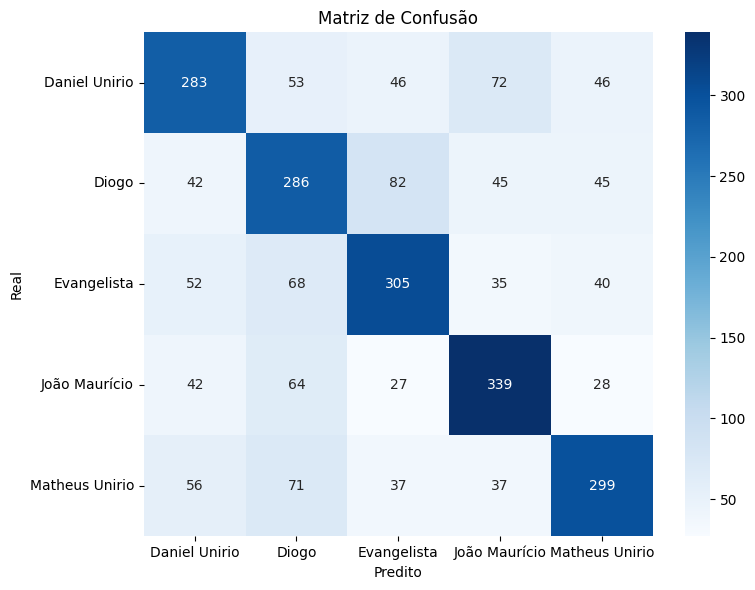

In [28]:
true_labels = teste_df['label'].values

# Matriz de confusão
cm = confusion_matrix(true_labels, predictions)

# Exibe usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

In [19]:
model.config.output_hidden_states = True
def get_cls_embeddings(model, tokenizer, texts, batch_size=8):
    embeddings = []

    for i in tqdm.tqdm(range(0, len(texts), batch_size), desc="Extraindo embeddings"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
        
        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states[-1]  # Última camada
            cls_embeddings = hidden_states[:, 0, :]     # Token [CLS]
            embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(embeddings)

In [20]:
# 1. Extrair embeddings
texts = list(teste_df['mensagem'].values)
cls_embeddings = get_cls_embeddings(model, tokenizer, texts)

# 2. Reduzir para 2 dimensões com t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(cls_embeddings)

Extraindo embeddings: 100%|██████████| 313/313 [00:39<00:00,  7.86it/s]


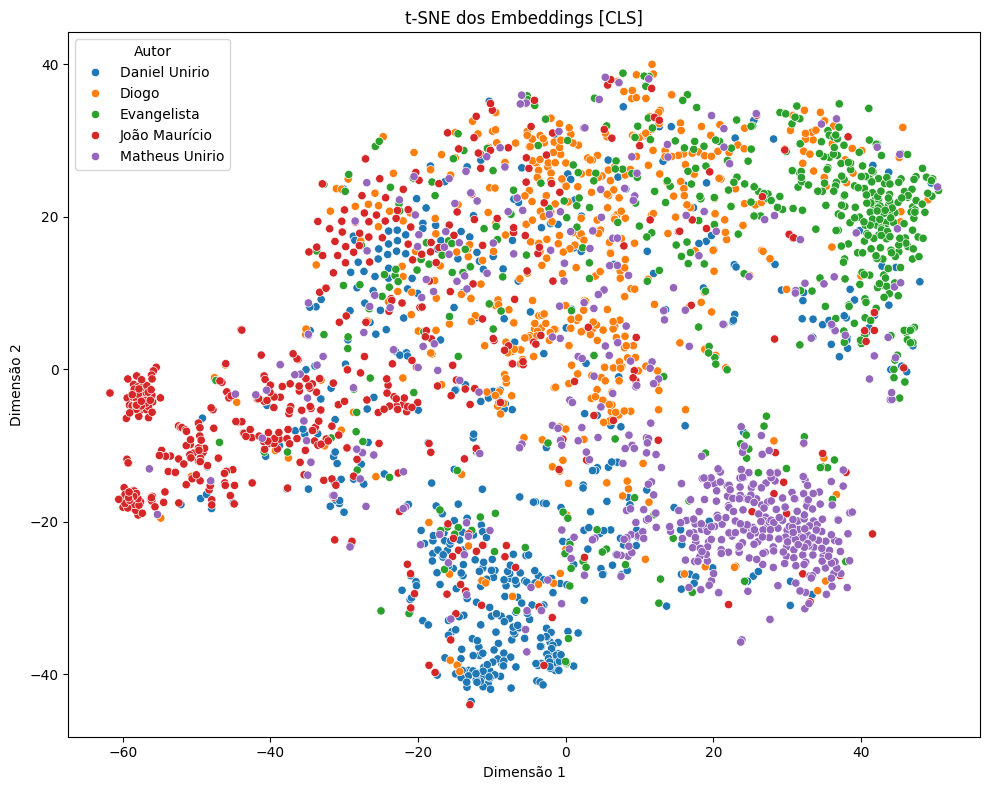

In [23]:
labels = label_encoder.inverse_transform(teste_df['label'].values)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette="tab10", alpha=1)
plt.title('t-SNE dos Embeddings [CLS]')
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.legend(title="Autor")
plt.tight_layout()
plt.show()